In [1]:
!pip install tensorflow


In [2]:
import numpy as np
import os
import cv2
import matplotlib.pyplot as plt
import tensorflow as tf
from tqdm import tqdm
import seaborn as sns

from sklearn.model_selection import train_test_split
from keras.utils import to_categorical
from sklearn.metrics import confusion_matrix
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Input, Conv2D, SeparableConv2D, BatchNormalization, Activation, MaxPooling2D, GlobalMaxPooling2D, Dropout, Dense, Add
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.metrics import F1Score
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers.schedules import ExponentialDecay


- Carichiamo da kaggle la cartella contenente le immagini di dataset

In [4]:
import os
import zipfile

# 1. Verifica che il file kaggle.json sia presente
kaggle_json = "kaggle.json"

if not os.path.exists(kaggle_json):
    raise FileNotFoundError("Il file 'kaggle.json' non è stato trovato nella cartella corrente. ")

# 2. Copia kaggle.json nella cartella .kaggle dell’utente
print(" Configurazione dell'API Kaggle...")
kaggle_dir = os.path.expanduser("~/.kaggle")
os.makedirs(kaggle_dir, exist_ok=True)

with open(kaggle_json, "rb") as src:
    with open(os.path.join(kaggle_dir, "kaggle.json"), "wb") as dst:
        dst.write(src.read())

os.chmod(os.path.join(kaggle_dir, "kaggle.json"), 0o600)

# 3. Installa la libreria kaggle (se non è installata)
try:
    import kaggle
except ImportError:
    print(" Installazione della libreria kaggle...")
    !pip install -q kaggle

# 4. Scarica il dataset
print("\n Download del dataset da Kaggle...")
!kaggle datasets download -d fatemehmehrparvar/lung-disease -p ./dataset --force

# 5. Estrai lo ZIP
zip_path = "./dataset/lung-disease.zip"
extract_path = "./lung_decompressed"

print(" Estrazione del file zip...")
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

# 6. Verifica i file
print("\n Download e decompressione completati.")
print(" File estratti:")
print(os.listdir(extract_path))

 Configurazione dell'API Kaggle...

 Download del dataset da Kaggle...



  0%|          | 0.00/34.9M [00:00<?, ?B/s]
100%|██████████| 34.9M/34.9M [00:00<00:00, 1.62GB/s]


Dataset URL: https://www.kaggle.com/datasets/fatemehmehrparvar/lung-disease
License(s): Attribution 4.0 International (CC BY 4.0)

 Estrazione del file zip...

 Download e decompressione completati.
 File estratti:
['Lung X-Ray Image']


- Definizione dei percorsi delle immagini

In [6]:
import os

base_dir = os.path.join(".", "lung_decompressed", "Lung X-Ray Image", "Lung X-Ray Image")

lung_opacity = os.path.join(base_dir, "Lung_Opacity")
normal = os.path.join(base_dir, "Normal")
viral_pne = os.path.join(base_dir, "Viral Pneumonia")

- Carichiamo le immagini negli array delle features e delle labels

In [7]:
features = []
labels = []

for img in tqdm(os.listdir(lung_opacity)):
    img_path = os.path.join(lung_opacity, img)
    image = cv2.imread(img_path)
    image = cv2.resize(image, (255, 255))
    features.append(image)

for img in tqdm(os.listdir(normal)):
    img_path = os.path.join(normal, img)
    image = cv2.imread(img_path)
    image = cv2.resize(image, (255, 255))
    features.append(image)

for img in tqdm(os.listdir(viral_pne)):
    img_path = os.path.join(viral_pne, img)
    image = cv2.imread(img_path)
    image = cv2.resize(image, (255, 255))
    features.append(image)

100%|██████████| 1100/1100 [00:15<00:00, 72.59it/s]


- Aggiungiamo le etichette per ogni classe

In [6]:
for img in os.listdir(lung_opacity):
    labels.append(0)
for img in os.listdir(normal):
    labels.append(1)
for img in os.listdir(viral_pne):
    labels.append(2)

- Mostriamo delle immagini casuali con le relative etichette

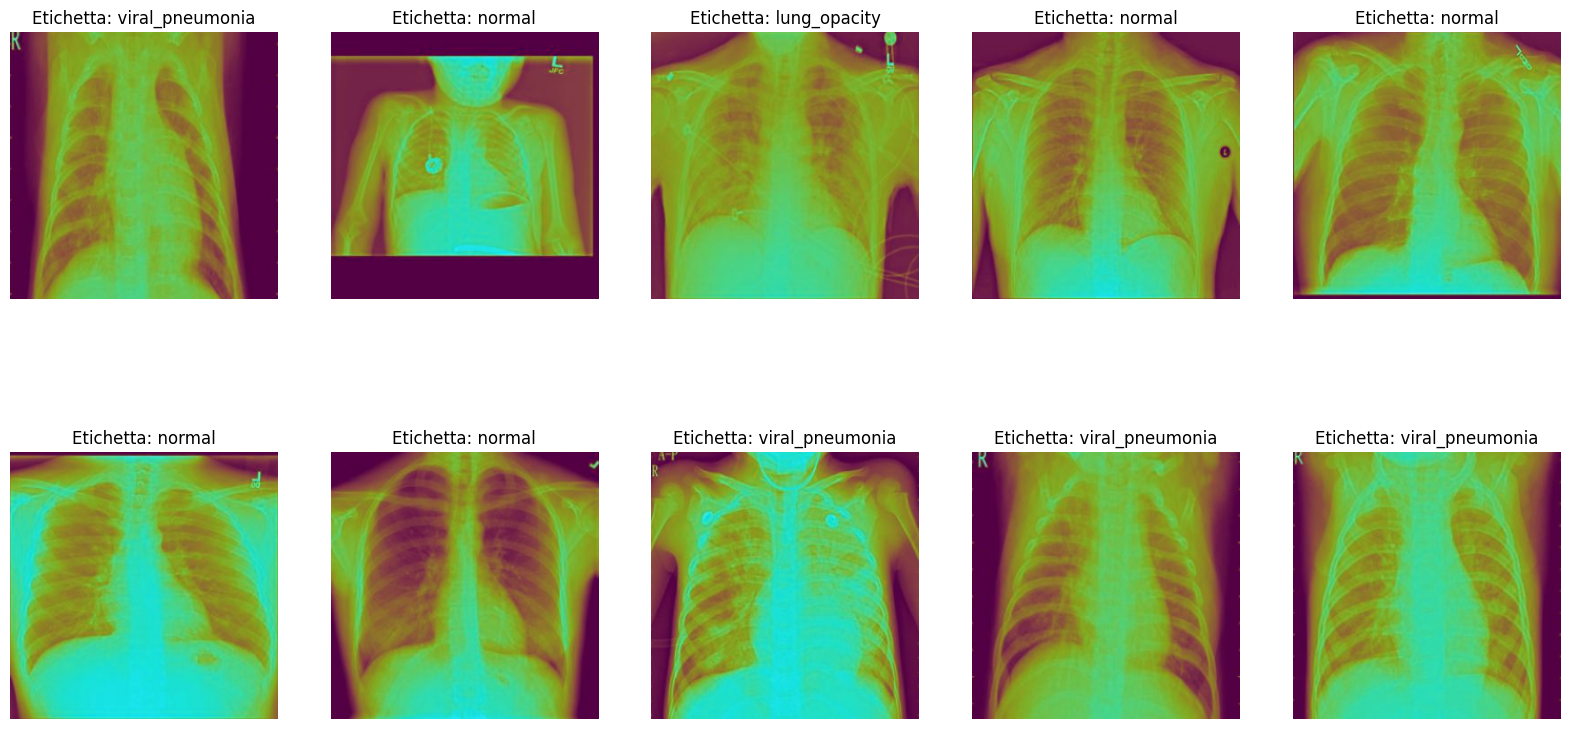

In [7]:
label_names = {0: 'lung_opacity', 1: 'normal', 2: 'viral_pneumonia'}

indices = np.arange(len(features))
np.random.shuffle(indices)
features = np.array(features)[indices]
labels = np.array(labels)[indices]

num_images_to_display = min(10, len(features))

plt.figure(figsize=(20, 10))
for i in range(num_images_to_display):
    plt.subplot(2, 5, i + 1)
    plt.imshow(features[i].astype('uint8'))
    plt.title(f'Etichetta: {label_names[labels[i]]}')
    plt.axis('off')
plt.show()

- Conversione delle features e delle labels in array numpy

In [8]:
X = np.array(features)
y = np.array(labels)

- Prima dividiamo in training e test set (80% training, 20% test)
- Poi dividiamo il training set rimanente in training e validation set (80% training, 20% validation)


In [9]:
X_train_all, X_test, y_train_all, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

X_train, X_val, y_train, y_val = train_test_split(X_train_all, y_train_all, test_size=0.2, random_state=42)

- Conversione delle etichette in formato categorico

In [10]:
y_trainE = to_categorical(y_train, num_classes=3)
y_valE = to_categorical(y_val, num_classes=3)
y_testE = to_categorical(y_test, num_classes=3)

# Modello
- Definizione del generatore di immagini aumentate
- Definizione, creazione e stampa del modello

In [11]:
import tensorflow as tf

def create_augmentation_model():
    datagen = tf.keras.Sequential([
        tf.keras.layers.RandomFlip("horizontal"),
        tf.keras.layers.RandomRotation(0.1),
        tf.keras.layers.RandomZoom(0.2)
    ])
    return datagen

def residual_block(x, filters):
    residual = x

    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation("relu")(x)
    x = tf.keras.layers.SeparableConv2D(filters, 3, padding="same", use_bias=False)(x)

    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation("relu")(x)
    x = tf.keras.layers.SeparableConv2D(filters, 3, padding="same", use_bias=False)(x)

    x = tf.keras.layers.MaxPooling2D(3, strides=2, padding="same")(x)
    residual = tf.keras.layers.Conv2D(filters, 1, strides=2, padding="same", use_bias=False)(residual)
    x = tf.keras.layers.add([x, residual])

    return x

def create_model():
    input_layer = tf.keras.layers.Input(shape=(255, 255, 3))

    x = tf.keras.layers.Rescaling(1./255)(input_layer)
    x = tf.keras.layers.Conv2D(filters=32, kernel_size=5, use_bias=False)(x)

    for filters in [32, 64, 128, 256, 512]:
        x = residual_block(x, filters)

    x = tf.keras.layers.GlobalMaxPooling2D()(x)
    x = Dropout(0.5)(x)
    x = Dense(128, activation='relu')(x)
    x = Dropout(0.5)(x)
    outputs = tf.keras.layers.Dense(3, activation="softmax")(x)

    model = tf.keras.Model(inputs=input_layer, outputs=outputs)
    return model

augmentation_model = create_augmentation_model()
model = create_model()

model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 255, 255, 3)]        0         []                            
                                                                                                  
 rescaling (Rescaling)       (None, 255, 255, 3)          0         ['input_1[0][0]']             
                                                                                                  
 conv2d (Conv2D)             (None, 251, 251, 32)         2400      ['rescaling[0][0]']           
                                                                                                  
 batch_normalization (Batch  (None, 251, 251, 32)         128       ['conv2d[0][0]']              
 Normalization)                                                                               

- Compilazione e addestramento del modello

In [ ]:
reduce_lr = ExponentialDecay(0.002,
    decay_steps=len(X_train)*13,
    decay_rate=0.66,
    staircase=True)

optimizer = Adam(learning_rate=reduce_lr)
model.compile(optimizer=optimizer,
              loss='categorical_crossentropy',
              metrics=['accuracy', tf.keras.metrics.F1Score()])

early_stopping = EarlyStopping(monitor='val_accuracy', patience=5, restore_best_weights=True)
model_checkpoint = ModelCheckpoint('best_model_CNN.keras', monitor='val_accuracy', save_best_only=True)

history = model.fit(X_train, y_trainE,  
                    validation_data=(X_val, y_valE),
                    epochs=30,
                    callbacks=[early_stopping, model_checkpoint])

Epoch 1/30
70/70 [==============================] - 40s 311ms/step - loss: 0.9095 - accuracy: 0.5270 - f1_score: 0.5272 - val_loss: 1.1580 - val_accuracy: 0.3813 - val_f1_score: 0.1840
Epoch 2/30
70/70 [==============================] - 18s 255ms/step - loss: 0.6131 - accuracy: 0.7082 - f1_score: 0.7108 - val_loss: 1.1250 - val_accuracy: 0.4029 - val_f1_score: 0.2529
Epoch 3/30
70/70 [==============================] - 18s 256ms/step - loss: 0.5255 - accuracy: 0.7738 - f1_score: 0.7776 - val_loss: 1.0192 - val_accuracy: 0.4388 - val_f1_score: 0.3000
Epoch 4/30
70/70 [==============================] - 18s 256ms/step - loss: 0.4919 - accuracy: 0.7972 - f1_score: 0.8005 - val_loss: 0.9923 - val_accuracy: 0.4119 - val_f1_score: 0.2513
Epoch 5/30
70/70 [==============================] - 18s 257ms/step - loss: 0.4175 - accuracy: 0.8264 - f1_score: 0.8291 - val_loss: 0.9511 - val_accuracy: 0.4820 - val_f1_score: 0.4450
Epoch 6/30
70/70 [==============================] - 18s 255ms/step - loss: 

- Valutazione e stampa dei risultati del modello

In [13]:
loss, accuracy, f1  = model.evaluate(X_test, y_testE)

print(f"Test loss: {loss:.3f}")
print(f"Test accuracy: {accuracy:.3f}")
print(f"f1: {np.mean(f1):.3f}")

22/22 [==============================] - 3s 120ms/step - loss: 0.3539 - accuracy: 0.8662 - f1_score: 0.8664
Test loss: 0.354
Test accuracy: 0.866
f1: 0.866


- Scatterplot

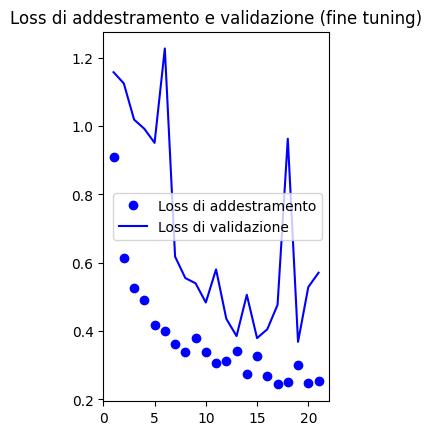

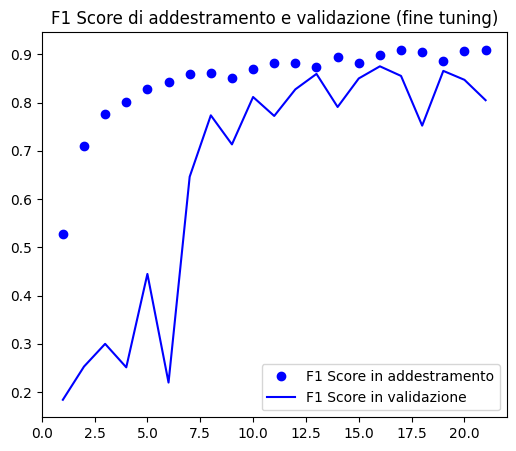

In [15]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

f1_score = []
val_f1_score = []

epochs = range(1, len(acc) + 1)

for i in range(len(acc)):
  f1_score.append(np.mean(history.history['f1_score'][i]))
  val_f1_score.append(np.mean(history.history['val_f1_score'][i]))

# Plot della perdita (loss)
plt.subplot(1, 2, 2)
plt.plot(epochs, loss, "bo", label="Loss di addestramento")
plt.plot(epochs, val_loss, "b", label="Loss di validazione")
plt.title("Loss di addestramento e validazione (fine tuning)")
plt.legend()

plt.show()

# Plot dell'F1 score
plt.figure(figsize=(6, 5))
plt.plot(epochs, f1_score, "bo", label="F1 Score in addestramento")
plt.plot(epochs, val_f1_score, "b", label="F1 Score in validazione")
plt.title("F1 Score di addestramento e validazione (fine tuning)")
plt.legend()

plt.show()

# Matrice di confusione

22/22 [==============================] - 1s 51ms/step


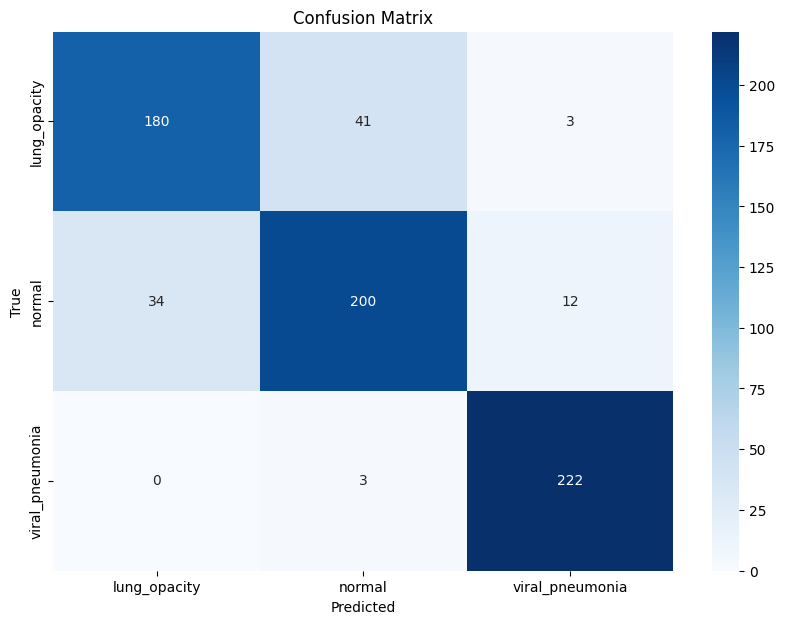

In [21]:
y_predE = model.predict(X_test)
y_pred = np.argmax(y_predE, axis=1)
y_true = np.argmax(y_testE, axis=1)

cm = confusion_matrix(y_true, y_pred)
cm_labels = ['lung_opacity', 'normal', 'viral_pneumonia']

plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=cm_labels, yticklabels=cm_labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()